## 30 - Basic Radar Plotting Part 2

[Youtube](https://www.youtube.com/watch?v=fSax8g9EfxM)

In [1]:
from datetime import datetime, timedelta
from siphon.catalog import TDSCatalog
from siphon.radarserver import RadarServer

In [2]:
cat = TDSCatalog('http://thredds.ucar.edu/thredds/radarServer/catalog.xml')

In [3]:
rs = RadarServer(cat.catalog_refs['NEXRAD Level III Radar from IDD'].href)

In [4]:
query = rs.query()
now = datetime.utcnow()
query.stations('FTG').time_range(now - timedelta(hours = 1), now).variables('N0C')

var=N0C&time_start=2022-12-22T17%3A56%3A27.585981&time_end=2022-12-22T18%3A56%3A27.585981&stn=FTG

In [5]:
query_cat = rs.get_catalog(query)

In [6]:
import cartopy
import matplotlib.pyplot as plt
import numpy as np
from siphon.cdmr import Dataset
%matplotlib inline

In [7]:
data = query_cat.datasets[0].remote_access()
print(list(data.variables))

['elevation', 'azimuth', 'gate', 'latitude', 'longitude', 'altitude', 'rays_time', 'CorrelationCoefficient_RAW', 'CorrelationCoefficient']


In [8]:
field_name = 'CorrelationCoefficient'

In [9]:
range_data = data.variables['gate'][:]
azimuth_data = data.variables['azimuth'][:]
radar_data = data.variables[field_name][:]

In [10]:
x = range_data * np.sin(np.deg2rad(azimuth_data))[:, None]
y = range_data * np.cos(np.deg2rad(azimuth_data))[:, None]

In [11]:
radar_data = np.ma.array(radar_data, mask = np.isnan(radar_data))

In [12]:
proj = cartopy.crs.LambertConformal(central_longitude = data.RadarLongitude, central_latitude = data.RadarLatitude)

In [13]:
print(data.time_coverage_start)
data_time = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%SZ')
print(data_time)

2022-12-22T18:28:18Z
2022-12-22 18:28:18


In [14]:
from metpy.plots import ctables, add_timestamp, add_metpy_logo

In [15]:
state_borders = cartopy.feature.NaturalEarthFeature(category = 'cultural', name = 'admin_1_states_provinces_lakes', scale = '50m', facecolor = 'none')

/home/jessica/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/jessica/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/jessica/anaconda3/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_li

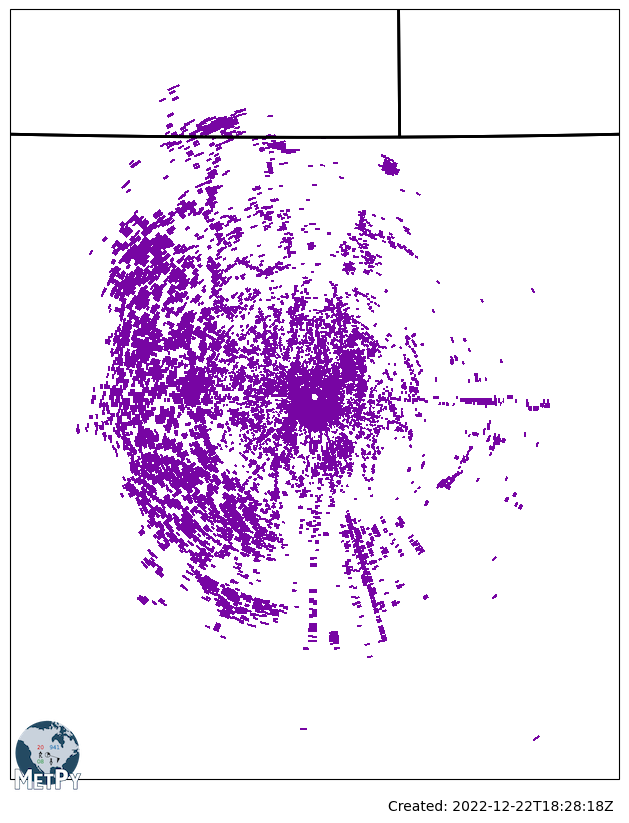

In [16]:
fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(1, 1, 1, projection = proj)

norm, cmap = ctables.registry.get_with_steps('Carbone42', 16, 16)
mesh = ax.pcolormesh(x, y, radar_data, norm = norm, cmap = cmap, zorder = 0)
add_timestamp(ax, time = data_time)
add_metpy_logo(fig, y = 30)
ax.add_feature(state_borders, edgecolor = 'black', linewidth = 2, zorder = 2)

distance_in_degrees = 1.8
ax.set_extent([data.RadarLongitude - distance_in_degrees, data.RadarLongitude + distance_in_degrees, data.RadarLatitude - distance_in_degrees, data.RadarLatitude + distance_in_degrees])